In [1]:
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf
import imutils
import nibabel as nib
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib

from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from keras.layers.convolutional import Deconv2D as Conv2DTranspose
from tensorflow.keras.losses import binary_crossentropy

In [2]:
df = pd.read_csv('./metadata.csv')

In [3]:
df.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [4]:
img_size = 224
def cropper(img):

    img = np.uint8(img*255)   
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]  
    x = np.argsort(areas)   
    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]   
      
    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)
    
    a=min(x,p)
    b=min(y,q)
    c=max(x+w,p+r)
    d=max(y+h,q+s)
    
    cropped= img[b:d, a:c]
    cropped = cv2.resize(cropped, dsize=(250,250), interpolation=cv2.INTER_AREA)
    
    points_lungs = []
    
    points_lungs.append(a); points_lungs.append(b); points_lungs.append(c); points_lungs.append(d)
    
    
    return(cropped, points_lungs)

In [5]:
def clahe_enhancer(img):
    xma=img.max()
    xmi=img.min()
    img=(img-xmi)/(xma-xmi)
    img = np.uint8(img*225)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    return clahe_img

In [6]:
all_points = []


def read_nii(filepath, data):
    
    global all_points
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))

    for img_no in range(0, array.shape[0]):
        img=cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax=img.max()
        xmin=img.min()
        img=(img - xmin)/(xmax - xmin)
        data.append(img)

In [7]:
cts = []
lungs = []
img_size = 224
for i in range(0, 20):
    read_nii(df.loc[i,'lung_mask'], lungs)
    read_nii(df.loc[i,'ct_scan'], cts)

len(cts), len(lungs)

<ipython-input-6-e3d0d1e7e605>:18: RuntimeWarning: invalid value encountered in true_divide
  img=(img - xmin)/(xmax - xmin)


(2112, 2112)

In [8]:
nan_list = []
for img_id in range(len(lungs)):
    if np.isnan(lungs[img_id].sum()):
        nan_list.append(img_id)
print(nan_list)

[1368, 1369, 1370, 1371, 1928, 1929]


In [9]:
del lungs[1368:1372]
del cts[1368:1372]
del lungs[1924:1926]
del cts[1924:1926]

In [10]:
new_lungs = []
new_cts = []

for img_id in range(len(lungs)):
    lung_img = lungs[img_id]
    lung_img[lung_img>0] = 1
    cropped_lung, points = cropper(lung_img)
    cropped_lung = cv2.resize(cropped_lung, (224, 224))
    new_lungs.append(cropped_lung)
    cts_img = cts[img_id]
    cts_img = clahe_enhancer(cts_img)
    a,b,c,d = points[0], points[1], points[2], points[3]
    img = cts_img[b:d, a:c]
    img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
    new_cts.append(img)
    
print(len(new_cts), len(new_lungs))

2106 2106


In [11]:
new_cts = np.uint8(np.array(new_cts))
new_lungs = np.uint8(np.array(new_lungs))
new_cts = new_cts/255
new_lungs = new_lungs/255

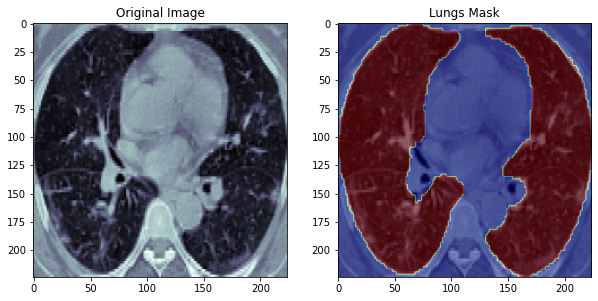

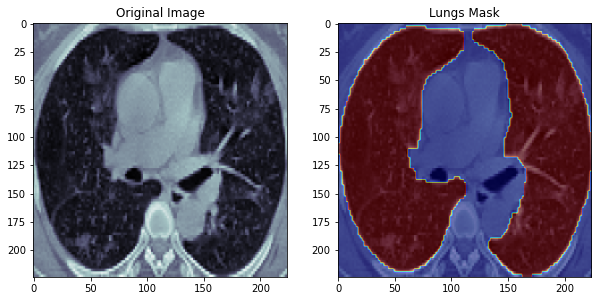

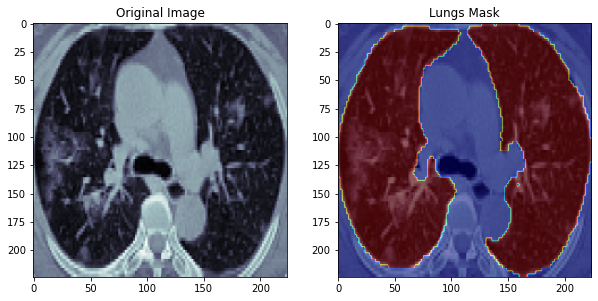

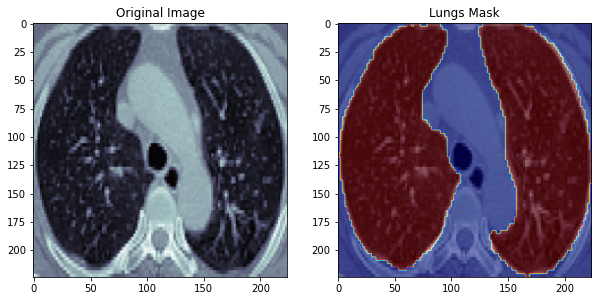

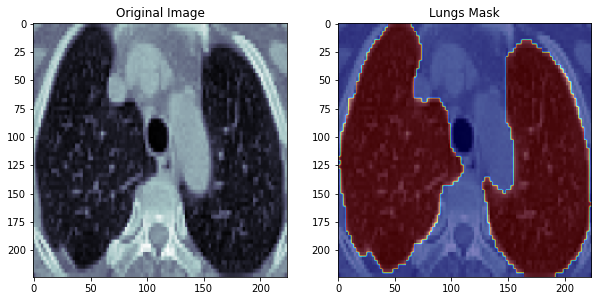

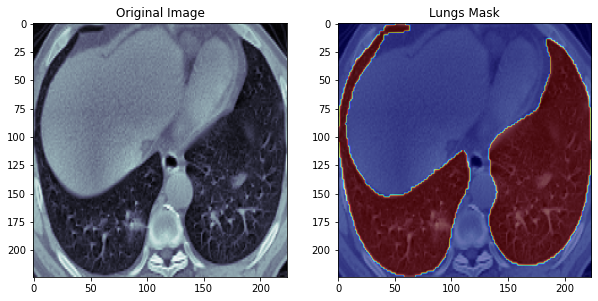

In [12]:
def plot_sample(array_list, color_map = 'jet'):
    
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(224, 224), cmap='bone')
    plt.imshow(array_list[1].reshape(224, 224), alpha=0.5, cmap=color_map)
    plt.title('Lungs Mask')
    plt.show()

for index in [100,120,140,160,180,200]:
    plot_sample([new_cts[index], new_lungs[index]])

In [13]:
aug_cts = []
aug_lungs = []

def augmentation(imgs, masks):
    for i in range(imgs.shape[0]):
        img = imgs[i,:,:]
        mask = masks[i,:,:]
        aug_cts.append(img)
        aug_lungs.append(mask)

        img_lr = np.fliplr(img)
        mask_lr =np.fliplr(mask)
        img_ud = np.flipud(img)
        mask_ud = np.flipud(mask)
        aug_cts.append(img_lr)
        aug_lungs.append(mask_lr)
        aug_cts.append(img_ud)
        aug_lungs.append(mask_ud)

augmentation(new_cts, new_lungs)
new_cts = np.array(aug_cts)
new_lungs = np.array(aug_lungs)

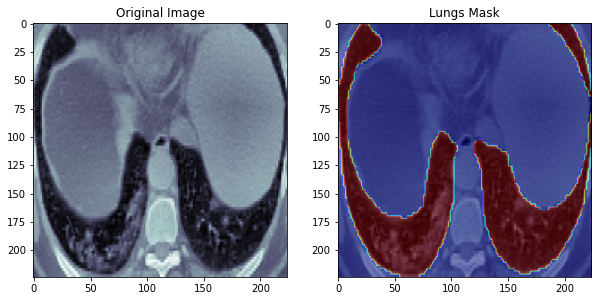

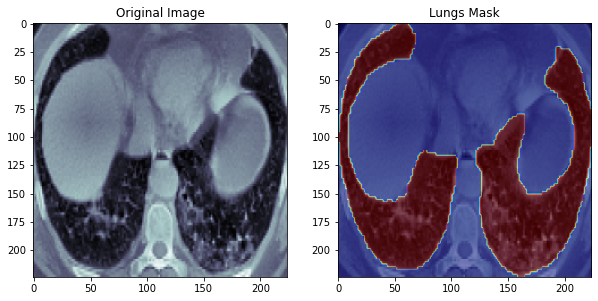

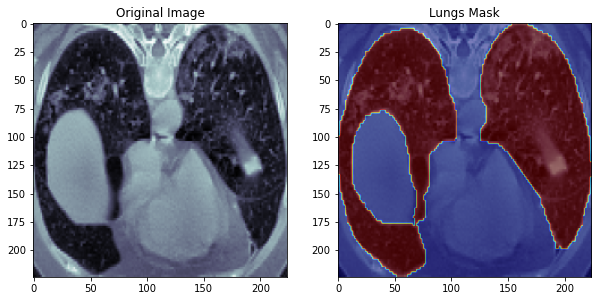

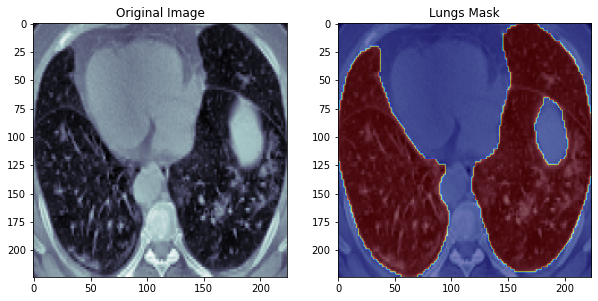

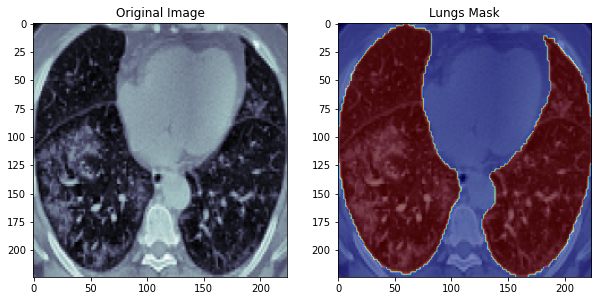

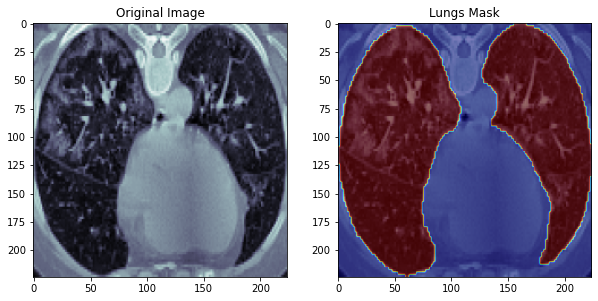

In [14]:
for index in [100,120,140,160,180,200]:
    plot_sample([new_cts[index], new_lungs[index]])

In [15]:
from tensorflow.keras.layers import concatenate, Add
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [16]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [17]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

In [18]:
def Generator(X_list, y_list, batch_size = 32):
    c = 0
    while True:

        X = X_list[c:c+batch_size, :,:]
        y = y_list[c:c+batch_size, :, :]

        X = X[:,:,:,np.newaxis]
        y = y[:,:,:,np.newaxis]

        c += batch_size
        if (c+batch_size >= len(X_list)):
            c = 0
        yield X, y

In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(
    new_cts, new_lungs, test_size=0.2, random_state=42)

epochs = 80
batch_size = 16
steps_per_epoch = int(len(x_train) / batch_size)
validation_steps = int(len(x_valid) / batch_size)

train_gen = Generator(x_train, y_train, batch_size = batch_size)
val_gen = Generator(x_valid, y_valid, batch_size = batch_size)

inputs = Input((img_size, img_size, 1))
output_layer = build_model(inputs, 16, 0.5)

checkpoint = ModelCheckpoint(filepath = 'best_lungs_224_res.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
clf = Model(inputs=[inputs], outputs=[output_layer])
clf.compile(optimizer=Adam(lr = 3e-5), loss=dice_loss, metrics=[dice_coef])

earlystop=EarlyStopping(monitor='val_dice_coef',patience=3,baseline=0.95)
checkpointer=[checkpoint,earlystop]

In [ ]:
results = clf.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs,
                             validation_data = val_gen, validation_steps = validation_steps,callbacks=checkpointer)

In [ ]:
clf.load_weights("lungs_seg_model.h5")

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('dice loss')
acc_ax.set_ylabel('dice coefficient')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss, test dice coefficient:", score)